In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  1.15.2


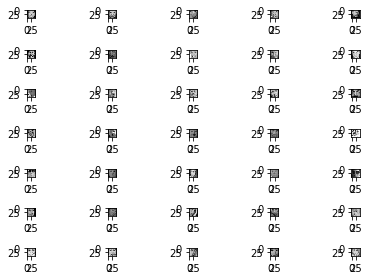

In [12]:
#plotting image
ctr = 0
for expression in os.listdir("train/"):
    for i in range(1,6):
        ctr += 1
        plt.subplot(7,5,ctr)
        img = load_img("train/"+expression+"/"+os.listdir("train/"+expression)[i],(48,48))
        plt.imshow(img, cmap='gray')

plt.tight_layout()

In [13]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+" "+expression+" images")

3196 Angry images
349 Disgust images
3278 Fear images
5772 Happy images
3972 Neutral images
3864 Sad images
2537 Surprise images


In [14]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size=(img_size, img_size),
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                   target_size=(img_size, img_size),
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


**our cnn model inspired by the following paper https://arxiv.org/abs/1307.0414**

In [16]:
model = Sequential()

# 1st Conv layer
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd Conv layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd Conv layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4th Conv layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________

### Training and evaluating our model

In [ ]:
epochs = 1
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# to save the weights of best model with highest validation accuracy
checkpoint = ModelCheckpoint('model_weight.hs', monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

# reducing the Learning rate if no chnage in loss for some strps
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

callbacks = [checkpoint, reduce_lr]

history = model.fit(x=train_generator,
                   steps_per_epoch=steps_per_epoch,
                   epochs=epochs,
                   validation_data=validation_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)

112/358 [========>.....................] - ETA: 11:46 - loss: 1.5925 - acc: 0.3991

In [ ]:
#saving the weight to json
model_json = model.to_json()

with open('model.json','w') as json_file:
    json_file.write(model_json)